<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/CLTV_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Customer Lifetime Value(CLTV)
"Customer Lifetime Value is a monetary value that represents the amount of revenue or profit a customer will give the company over the period of the relationship" (Source). CLTV demonstrates the implications of acquiring long-term customers compare to short-term customers. Customer lifetime value (CLV) can help us to answers the most important questions about sales to every company: 
- How to Identify the most profitable customers?
- How can a company offer the best product and make the most money?
- How to segment profitable customers?
- How much budget need to spend to acquire customers?
##Calculate Customer Lifetime Value
There are lots of approaches available for calculating CLTV. Everyone has their own view on it. 
- We can compute it by adding profit/revenue from customers in a given cycle. For Example, if the customer is associated with the business for the last 3 years, we can sum all the profit in this 3 years. We can average the profit yearly or half-yearly or monthly, but in this approach, we won's be able to build a predictive model for new customers.
- Build a regression model for existing customers. Take recent six-month data as independent variables and total revenue over three years as a dependent variable and build a regression model on this data.
- CLTV can also implement using RFM(Recency, Frequency, Monetary) values. For more details, you can refer to my tutorial.
- Using the following equation: CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.
    -  Customer Value = Average Order Value * Purchase Frequency
    - Average Order Value(AOV) = Total Revenue / Total Number of Orders. AOV represents the mean amount of revenue that the customer spends on an order.
    - Purchase Frequency =  Total Number of Orders / Total Number of Customers. It represents the average number of orders placed by each customer.
    - Churn Rate: Churn Rate is the percentage of customers who have not ordered again.
    - Customer Lifetime = 1/ churn rate
    - Churn Rate= 1-Repeat Rate

In [235]:
!pip install lifetimes

In [312]:
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np
import io
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import xlrd
import pandas as pd
import datetime

#Importing Lifetimes Liabraries
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
import pickle
from lifetimes import ModifiedBetaGeoFitter
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

In [313]:
from google.colab import files
uploaded = files.upload()

Saving online_retail_II.xlsx to online_retail_II (1).xlsx


In [314]:
data = pd.read_excel(io.BytesIO(uploaded.get('online_retail_II.xlsx'))) #reading the excel file#

In [315]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Brand
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2020-12-01 07:45:00,6.95000,13085.00000,United Kingdom,2
1,489434,79323P,PINK CHERRY LIGHTS,12,2020-12-01 07:45:00,6.75000,13085.00000,United Kingdom,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2020-12-01 07:45:00,6.75000,13085.00000,United Kingdom,2
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2020-12-01 07:45:00,2.10000,13085.00000,United Kingdom,4
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2020-12-01 07:45:00,1.25000,13085.00000,United Kingdom,2


In [316]:
data.shape

(525461, 9)

In [317]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   CustomerID   417534 non-null  float64       
 7   Country      525461 non-null  object        
 8   Brand        525461 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 36.1+ MB


In [318]:
data.isnull().sum()/data.shape[0]*100

Invoice        0.00000
StockCode      0.00000
Description    0.55722
Quantity       0.00000
InvoiceDate    0.00000
Price          0.00000
CustomerID    20.53949
Country        0.00000
Brand          0.00000
dtype: float64

In [319]:
# first drop the rows where the description is null
data.dropna(axis = 0, subset = ["Description"], inplace = True)

In [320]:
data.isnull().sum() #Now let's check the data before droping these customer ID's

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
CustomerID     104999
Country             0
Brand               0
dtype: int64

In [321]:
data[data["CustomerID"].isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Brand
263,489464,21733,85123a mixed,-96,2020-12-01 10:52:00,0.00000,NaN,United Kingdom,0
283,489463,71477,short,-240,2020-12-01 10:52:00,0.00000,NaN,United Kingdom,0
284,489467,85123A,21733 mixed,-192,2020-12-01 10:53:00,0.00000,NaN,United Kingdom,2
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2020-12-01 11:49:00,0.55000,NaN,United Kingdom,1
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2020-12-01 11:49:00,0.85000,NaN,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
525145,538154,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2021-12-09 16:35:00,8.47000,NaN,United Kingdom,0
525146,538154,85099B,JUMBO BAG RED RETROSPOT,1,2021-12-09 16:35:00,4.21000,NaN,United Kingdom,0
525147,538154,DOT,DOTCOM POSTAGE,1,2021-12-09 16:35:00,85.79000,NaN,United Kingdom,0
525234,538161,46000S,Dotcom sales,-100,2021-12-09 17:25:00,0.00000,NaN,United Kingdom,0


In [322]:
data.iloc[575:, :]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Brand
576,C489524,21258,VICTORIAN SEWING BOX LARGE,-1,2020-12-01 11:48:00,12.75000,15614.00000,United Kingdom,0
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2020-12-01 11:49:00,0.55000,NaN,United Kingdom,1
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2020-12-01 11:49:00,0.85000,NaN,United Kingdom,0
579,489526,85049E,SCANDINAVIAN REDS RIBBONS,12,2020-12-01 11:50:00,1.25000,12533.00000,Germany,0
580,489526,21976,PACK OF 60 MUSHROOM CAKE CASES,24,2020-12-01 11:50:00,0.55000,12533.00000,Germany,0
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2021-12-09 20:01:00,2.95000,17530.00000,United Kingdom,0
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2021-12-09 20:01:00,3.75000,17530.00000,United Kingdom,2
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2021-12-09 20:01:00,3.75000,17530.00000,United Kingdom,2
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2021-12-09 20:01:00,3.75000,17530.00000,United Kingdom,0


In [323]:
# We have to drop the rows where customer ID is null because it's a unique customer ID of each customer
# So it's better to drop rather than imputing it with some random value

data.dropna(axis = 0, subset = ["CustomerID"], inplace = True)

In [324]:
data.isnull().sum() #Now's there is no null values available in our data

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
Brand          0
dtype: int64

In [325]:
data.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Brand
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2020-12-01 07:45:00,6.95000,13085.00000,United Kingdom,2
1,489434,79323P,PINK CHERRY LIGHTS,12,2020-12-01 07:45:00,6.75000,13085.00000,United Kingdom,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2020-12-01 07:45:00,6.75000,13085.00000,United Kingdom,2
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2020-12-01 07:45:00,2.10000,13085.00000,United Kingdom,4
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2020-12-01 07:45:00,1.25000,13085.00000,United Kingdom,2
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2020-12-01 07:45:00,1.65000,13085.00000,United Kingdom,1
6,489434,21871,SAVE THE PLANET MUG,24,2020-12-01 07:45:00,1.25000,13085.00000,United Kingdom,0
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2020-12-01 07:45:00,5.95000,13085.00000,United Kingdom,0
8,489435,22350,CAT BOWL,12,2020-12-01 07:46:00,2.55000,13085.00000,United Kingdom,2
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2020-12-01 07:46:00,3.75000,13085.00000,United Kingdom,3


Removing Duplicates
Sometimes we get a messy dataset. we may have to deal with duplicates, which will skew your analysis. 

In [326]:
filtered_data=data[['Country','CustomerID']].drop_duplicates()

Let's Jump into Data Insights

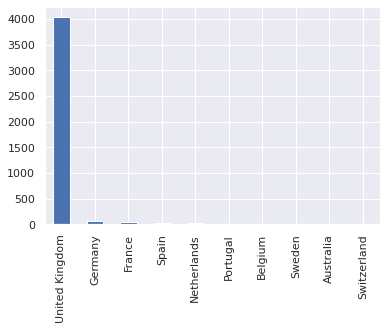

In [327]:
#Top ten country's customer
filtered_data.Country.value_counts()[:10].plot(kind='bar')
plt.show()

In [328]:
temp_df = pd.DataFrame(data["Country"].value_counts())

In [329]:
temp_df.head(10)

,Country
United Kingdom,379423
EIRE,8710
Germany,8129
France,5710
Netherlands,2769
Spain,1278
Switzerland,1187
Belgium,1054
Portugal,1024
Channel Islands,906


In [330]:
names  = temp_df.index

In [331]:
px.scatter(temp_df, y = "Country", color = names, title = "Count of Countries")

In [332]:
#Now let's check the total quantity and by country
data.groupby("Country").sum()["Quantity"].sort_values(ascending = False).head(10)
#data.groupby("Country").sum()["Quantity"].sort_values(ascending = False).tail(10)

Country
United Kingdom    4344969
Denmark            227030
Netherlands        181823
EIRE               177044
Germany            107133
France              73490
Sweden              52100
Switzerland         22053
Australia           20053
Spain               18332
Name: Quantity, dtype: int64

In [333]:
px.scatter(data.iloc[:, [5, 7]].groupby(["Country"]).mean(), 
           y = "Price", size = "Price", title = "Average Price by Country", opacity = 0.48)

From the above dot plot we can conclude that the Singapore has the highest averge price followed by the Norway and Malta. Let's go deeper and see the distribution to better understand about our data.

In [334]:
countries = data["Country"].unique()

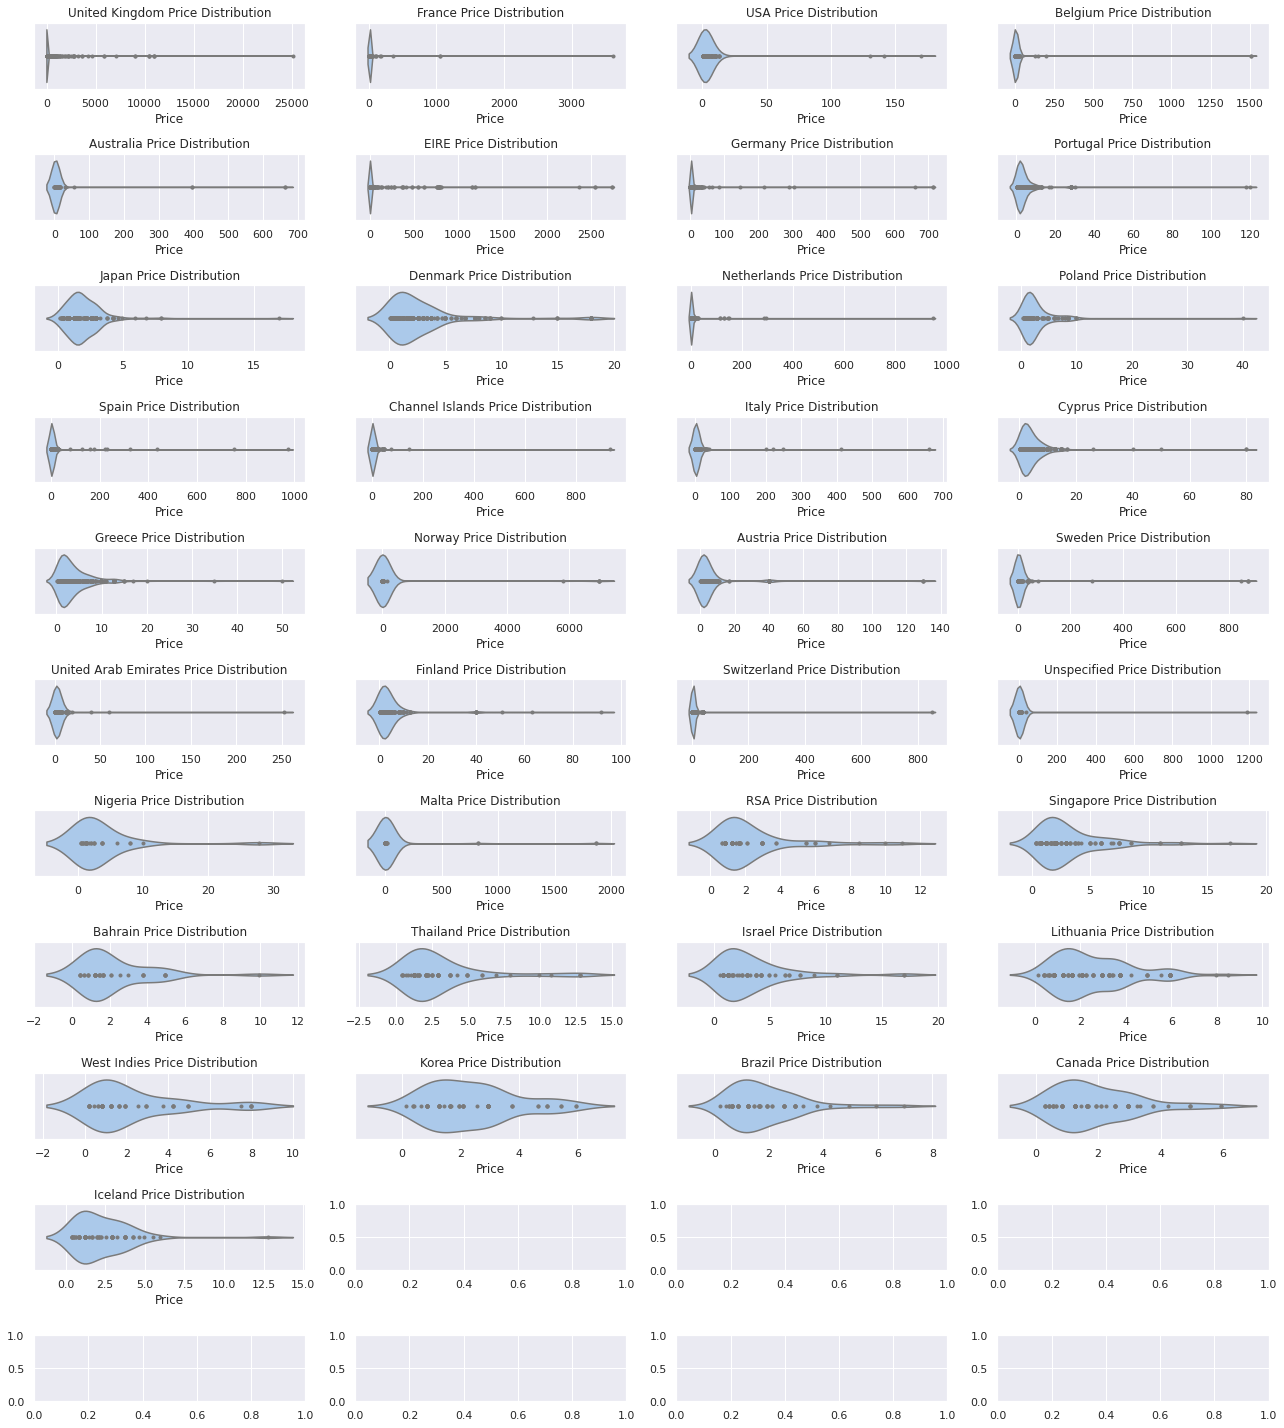

In [335]:
fig, ax = plt.subplots(11, 4, figsize=(18,20))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i, c in enumerate(countries):
    sns.violinplot(x = "Price", data = data[data["Country"] == c], ax = axes_[i], inner = "point", palette = "pastel")
    axes_[i].set_title(c + ' ' + "Price Distribution")
    plt.tight_layout()

From the above plot what I can interpret is that most of the data is pretty skewed and there is lot's of high extreme values that are present in the data.

In [336]:
#Total Number of Unique Invoices 
len(data["Invoice"].unique())

23576

In [337]:
temp_invoice_df = data.groupby("Invoice").sum()

In [338]:
temp_invoice_df.reset_index(inplace = True)

In [339]:
#Below are the top 30 invoices with total quantity purchased by them
temp_invoice_df.sort_values(by = "Quantity", ascending = False).head(30).iloc[:,:2].style.background_gradient(cmap = "Blues")

,Invoice,Quantity
11079,518505,87167
13416,524174,87167
3063,497946,83774
4378,501534,63974
2095,495194,63302
4692,502269,40000
1603,493819,25018
1047,491812,20524
7528,509472,17766
246,490018,17520


In [340]:
data.groupby(["Invoice"]).mean().head(15).iloc[:, [1]].sort_values("Price", ascending = False)

,Price
Invoice,
489444,141.00000
489447,130.00000
489434,4.08125
489436,3.73053
489437,3.62826
489439,3.56000
489440,3.15000
489446,3.11852
489441,3.04250


I have grouped the data by Invoice to see the average spend by Invoice Number. Here one thing interesting to see that the invoice with number 536374 & 536369 has outspent others. So to gain some better clarity, let's check these 2 invoices and get insights on how much quantity they have purchased so far.

In [341]:
data[(data["Invoice"] == 489444) | (data["Invoice"] == 489447)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Brand
126,489444,POST,POSTAGE,1,2020-12-01 09:55:00,141.00000,12636.00000,USA,2
173,489447,POST,POSTAGE,1,2020-12-01 10:10:00,130.00000,12362.00000,Belgium,0


As we can see above, These 2 invoices with invoice number 536369 and 536374 had only single transaction, that's why the average price was too high.

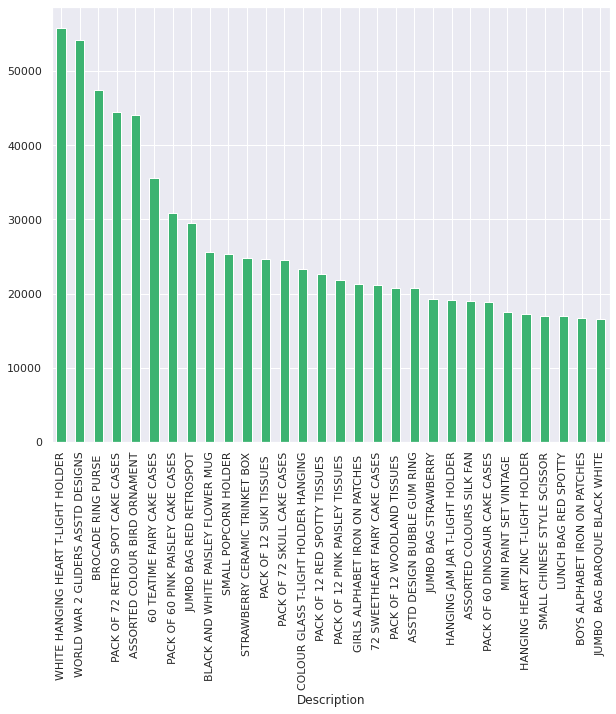

In [342]:
#Let's check which product has been purchased more often so far
plt.figure(figsize=(10,8))
data.groupby("Description").sum().sort_values(by = "Quantity", ascending = False).head(30)["Quantity"].plot(kind = "bar", color = 'mediumseagreen')

**Top 8 Countries With Most Transactions**

In [343]:
temp = data.groupby(["Country", "Description"]).sum()["Quantity"]

In [344]:
temp = pd.DataFrame(temp)

In [345]:
top_8_countries = ["United Kingdom", "Netherlands", "EIRE", "Denmark", "Germany", "France", "Australia", "Sweden"]

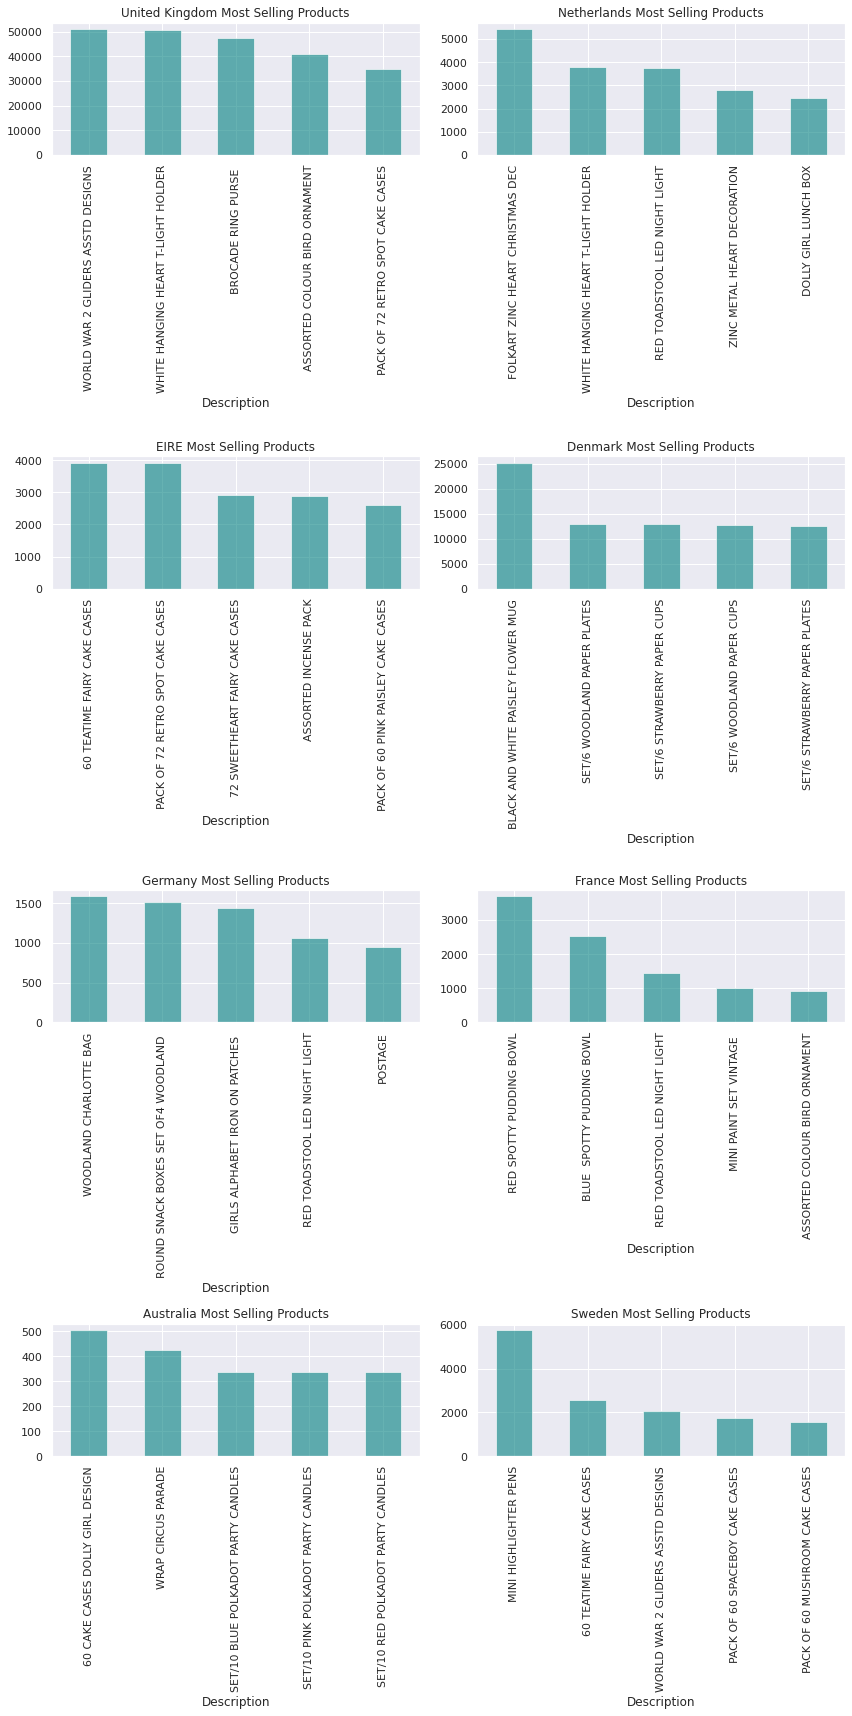

In [346]:
x = 1
plt.figure(figsize=(12,24))
for x, c in enumerate(top_8_countries):
    ax = plt.subplot(4,2, x+1)
    plt.title(c + ' '+ "Most Selling Products")
    temp.loc[c].sort_values(by = "Quantity", ascending = False)["Quantity"].head(5).plot(kind = "bar", ax = ax, color = "teal", alpha = 0.6)
    plt.tight_layout()

#### Filter required Columns
Here, we can filter the necessary columns for calculating CLTV. We only need here five columns CustomerID, InvoiceDate, InvoiceNo, Quantity, and UnitPrice.
 - CustomerID will uniquely define our customers.
 - InvoiceDate help us calculate numbers of days customer stayed with your product.
 - InvoiceNo helps us to count the number of time transaction performed(frequency).
 - Quantity is purchased item units in each transaction
 - UnitPrice of each unit purchased by the customer will help us to calculate the total purchased amount.

Here, we are going to perform the following operations:

Calculate the number of days between the present date and the date of last purchase from each customer.
Calculate the number of orders for each customer.
Calculate sum of purchase price for each customer.

In [347]:
# Preparing the Data 
data=data[~data["Invoice"].astype(str).str.contains("C",na=False)]
data=data[(data["Quantity"]>0)]
data.dropna(inplace=True)
data["TotalPrice"]=data["Quantity"]*data["Price"]

cltv_df= data.groupby("CustomerID").agg({'InvoiceDate': lambda date: (date.max()-date.min()).days,
                                        'Invoice': lambda num: len(num),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalPrice': lambda price: price.sum()})
#Renaming the column
cltv_df.columns=['num_days','total_transaction','total_unit','total_price']
cltv_df.head()

,num_days,total_transaction,total_unit,total_price
CustomerID,,,,
12346.00000,196,33,70,372.86000
12347.00000,37,71,828,1323.32000
12348.00000,0,20,373,222.16000
12349.00000,181,102,993,2671.14000
12351.00000,0,21,261,300.93000


## Calculate CLTV using following formula:
CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

Customer Value = Average Order Value * Purchase Frequency

In [348]:
# Average Order Value
cltv_df['avg_order_value']=cltv_df['total_price']/cltv_df['total_transaction']
cltv_df.head()

,num_days,total_transaction,total_unit,total_price,avg_order_value
CustomerID,,,,,
12346.00000,196,33,70,372.86000,11.29879
12347.00000,37,71,828,1323.32000,18.63831
12348.00000,0,20,373,222.16000,11.10800
12349.00000,181,102,993,2671.14000,26.18765
12351.00000,0,21,261,300.93000,14.33000


##  Calculate Purchase Frequency

In [349]:
##################################################
# 2. Calculate Purchase Frequency
##################################################

cltv_df.shape[0]
cltv_df["purchase_frequency"]=cltv_df["total_transaction"]/cltv_df.shape[0]
cltv_df["purchase_frequency"].head(10)

CustomerID
12346.00000   0.00765
12347.00000   0.01646
12348.00000   0.00464
12349.00000   0.02364
12351.00000   0.00487
12352.00000   0.00417
12353.00000   0.00464
12355.00000   0.00510
12356.00000   0.01947
12357.00000   0.03825
Name: purchase_frequency, dtype: float64

## Calculate Repeat Rate and Churn Rate

In [350]:
# repeat rate is the the number of customers who shopped at least 2 times in the dataset divided by the total number of customers
repeat_rate=cltv_df[cltv_df.total_transaction>1].shape[0]/cltv_df.shape[0]
#so the repeat_rate is 0.978442280945758
churn_rate = 1 - repeat_rate
churn_rate

0.021557719054241975

## Calculate Profit Margin
Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain. Let's assume our business has approx 5% profit on the total sale.

In [351]:
# We assume 5% profit from the total price and since it is unique for each customer, 
# we add this dataset, profit margin to this dataset.
cltv_df["profit_margin"]=cltv_df["total_price"]*0.05
cltv_df["profit_margin"].head()

CustomerID
12346.00000    18.64300
12347.00000    66.16600
12348.00000    11.10800
12349.00000   133.55700
12351.00000    15.04650
Name: profit_margin, dtype: float64

## Calcualte Customer Lifetime Value

In [352]:
# CLTV = (Customer_Value / Churn_Rate) x Profit_margin.
# Customer_Value = Average_Order_Value * Purchase_Frequency
cltv_df['CV']=(cltv_df['avg_order_value']/cltv_df['purchase_frequency'])/churn_rate
cltv_df['CLTV']=cltv_df['CV']*cltv_df["profit_margin"]

pd.set_option('display.float_format', lambda x: '%.5f' % x)
cltv_df.sort_values("CLTV",ascending=False).head()

,num_days,total_transaction,total_unit,total_price,avg_order_value,purchase_frequency,profit_margin,CV,CLTV
CustomerID,,,,,,,,,
12918.00000,0,1,1,10953.50000,10953.50000,0.00023,547.67500,2191947992.32258,1200475116695.27124
15760.00000,0,2,2,13916.34000,6958.17000,0.00046,695.81700,696213391.23290,484437113247.50568
13205.00000,0,1,256,2803.20000,2803.20000,0.00023,140.16000,560959383.94839,78624067254.20602
15202.00000,0,3,3,6001.49000,2000.49667,0.00070,300.07450,133442420.29634,40042667549.21536
12737.00000,0,2,2,3710.50000,1855.25000,0.00046,185.52500,185630689.40323,34439133651.53352


In [353]:
# to make more understandable and readable lets transform it

scaler=MinMaxScaler(feature_range=(1,100))
scaler.fit(cltv_df[["CLTV"]])
cltv_df["SCALED_CLTV"]=scaler.transform(cltv_df[["CLTV"]])
cltv_df.sort_values("CLTV",ascending=False)
pd.set_option('display.max_columns',20)
cltv_df[["total_transaction","total_unit","total_price","CLTV","SCALED_CLTV"]].sort_values(by="CLTV",ascending=False).head()

,total_transaction,total_unit,total_price,CLTV,SCALED_CLTV
CustomerID,,,,,
12918.00000,1,1,10953.50000,1200475116695.27124,100.00000
15760.00000,2,2,13916.34000,484437113247.50568,40.95024
13205.00000,1,256,2803.20000,78624067254.20602,7.48392
15202.00000,3,3,6001.49000,40042667549.21536,4.30221
12737.00000,2,2,3710.50000,34439133651.53352,3.84010


In [354]:
cltv_df.sort_values("total_price",ascending=False)
cltv_df["segment"]=pd.qcut(cltv_df["SCALED_CLTV"],4,labels=['D','C','B','A'])
cltv_df[["segment", "total_transaction", "total_unit", "total_price", "CLTV", "SCALED_CLTV"]].sort_values(
    by="SCALED_CLTV",
    ascending=False).head()

,segment,total_transaction,total_unit,total_price,CLTV,SCALED_CLTV
CustomerID,,,,,,
12918.00000,A,1,1,10953.50000,1200475116695.27124,100.00000
15760.00000,A,2,2,13916.34000,484437113247.50568,40.95024
13205.00000,A,1,256,2803.20000,78624067254.20602,7.48392
15202.00000,A,3,3,6001.49000,40042667549.21536,4.30221
12737.00000,A,2,2,3710.50000,34439133651.53352,3.84010


# Prediction Model for CLTV
Let's build the CLTV prediction model. 
Here, we are going to predict CLTV using Linear Regression Model.
Let's first use the data loaded and filtered above.

In [355]:
cltv_df.head()

,num_days,total_transaction,total_unit,total_price,avg_order_value,purchase_frequency,profit_margin,CV,CLTV,SCALED_CLTV,segment
CustomerID,,,,,,,,,,,
12346.00000,196,33,70,372.86000,11.29879,0.00765,18.64300,68516.51238,1277353.34035,1.00011,C
12347.00000,37,71,828,1323.32000,18.63831,0.01646,66.16600,52532.19066,3475844.92704,1.00029,B
12348.00000,0,20,373,222.16000,11.10800,0.00464,11.10800,111143.27977,1234579.55166,1.00010,C
12349.00000,181,102,993,2671.14000,26.18765,0.02364,133.55700,51377.57955,6861835.39183,1.00057,A
12351.00000,0,21,261,300.93000,14.33000,0.00487,15.04650,136553.93788,2054658.82631,1.00017,C


Extract month and year from InvoiceDate.

In [356]:
data['month_yr'] = data['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Brand,TotalPrice,month_yr
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2020-12-01 07:45:00,6.95000,13085.00000,United Kingdom,2,83.40000,Dec-2020
1,489434,79323P,PINK CHERRY LIGHTS,12,2020-12-01 07:45:00,6.75000,13085.00000,United Kingdom,1,81.00000,Dec-2020
2,489434,79323W,WHITE CHERRY LIGHTS,12,2020-12-01 07:45:00,6.75000,13085.00000,United Kingdom,2,81.00000,Dec-2020
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2020-12-01 07:45:00,2.10000,13085.00000,United Kingdom,4,100.80000,Dec-2020
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2020-12-01 07:45:00,1.25000,13085.00000,United Kingdom,2,30.00000,Dec-2020


The pivot table takes the columns as input, and groups the entries into a two-dimensional table in such a way that provides a multidimensional summarization of the data.

In [357]:
sale=data.pivot_table(index=['CustomerID'],columns=['month_yr'],values='TotalPrice',aggfunc='sum',fill_value=0).reset_index()
sale.head()

month_yr,CustomerID,Apr-2021,Aug-2021,Dec-2020,Dec-2021,Feb-2021,Jan-2021,Jul-2021,Jun-2021,Mar-2021,May-2021,Nov-2021,Oct-2021,Sep-2021
0,12346.00000,0.00000,0.00000,113.50000,0.00000,0.00000,90.00000,0.00000,142.31000,27.05000,0.00000,0.00000,0.00000,0.00000
1,12347.00000,0.00000,0.00000,0.00000,711.79000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,611.53000,0.00000
2,12348.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,222.16000
3,12349.00000,1068.52000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,200.00000,0.00000,1402.62000,0.00000
4,12351.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,300.93000,0.00000,0.00000


Let's sum all the months sales.

In [358]:
sale['CLV']=sale.iloc[:,2:].sum(axis=1)
sale.head()

month_yr,CustomerID,Apr-2021,Aug-2021,Dec-2020,Dec-2021,Feb-2021,Jan-2021,Jul-2021,Jun-2021,Mar-2021,May-2021,Nov-2021,Oct-2021,Sep-2021,CLV
0,12346.00000,0.00000,0.00000,113.50000,0.00000,0.00000,90.00000,0.00000,142.31000,27.05000,0.00000,0.00000,0.00000,0.00000,372.86000
1,12347.00000,0.00000,0.00000,0.00000,711.79000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,611.53000,0.00000,1323.32000
2,12348.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,222.16000,222.16000
3,12349.00000,1068.52000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,200.00000,0.00000,1402.62000,0.00000,1602.62000
4,12351.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,300.93000,0.00000,0.00000,300.93000


### Selecting Feature
Here, we need to divide the given columns into two types of variables dependent(or target variable) and independent variable(or feature variables). Select latest 6 month as independent variable.

In [359]:
X=sale[['Dec-2021','Nov-2021', 'Oct-2021','Sep-2021','Aug-2021','Jul-2021']]
y=sale[['CLV']]

### Splitting Data
To understand model performance, dividing the dataset into a training set and a test set is a good strategy.

We need to pass 3 parameters features, target, and test_set size. Additionally, we can use random_state as a seed value to maintain reproducibility, which means whenever we split the data will not affect the results. Also, if random_state is None, then random number generator uses np.random for selecting records randomly. It means if we don't set a seed, it is different each time.

In [360]:
#split training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [361]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

[-7.89917687]
[[1.97609999 1.11166675 1.8809865  2.60523263 2.12439463 1.84997896]]


### Model Fit 
In order to evaluate the overall fit of the linear model, we use the R-squared value. R-squared is the proportion of variance explained by the model. Value of R-squared lies between 0 and 1. Higher value or R-squared is considered better because it indicates the larger variance explained by the model.

In [362]:
from sklearn import metrics

# compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))

R-Square: 0.8841870896066149


This model has a higher R-squared (0.88). This model provides a better fit to the data.
Model Evaluation
For regression problems following evaluation metrics used:
- Mean Absolute Error (MAE) is the mean of the absolute value of the errors.
- Mean Squared Error (MSE) is the mean of the squared errors.
- Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors.

In [363]:
# calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))

# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 785.8542669698618
MSE 8512937.05944861
RMSE: 2917.693791241399


RMSE is more popular than MSE and MAE because RMSE is interpretable with y because of the same units.

# Pros and Cons of CLTV
- CLTV helps us to design an effective business plan and also provide a chance to scale our business.
- CLTV draw meaningful customer segments these segment can help us to identify needs of the different-different segment. 
- CLTV can figure out most profitable customers, but how we are going to make a profit from them, it depends on our strategy. 
Generally, CLTV models are confused and misused. Obsession with CLTV may create blunders. Companies only focus on finding the best customer group and focusing on them and repeat the business, but it’s also important to give attention to other customers.

# CLTV Model Definition
For the CLTV models, the following nomenclature is used:
- Frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.
- T represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

We have some cleaning to do, then create a new dataframe that contains CustomerID, InvoiceDate (remove the time) and add a new column — sales:

**RFM Estimation**

In [364]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.date
data = data[pd.notnull(data['CustomerID'])]
data = data[(data['Quantity']>0)]
data['Sales'] = data['Quantity'] * data['Price']
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Brand,TotalPrice,month_yr,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2020-12-01,6.95000,13085.00000,United Kingdom,2,83.40000,Dec-2020,83.40000
1,489434,79323P,PINK CHERRY LIGHTS,12,2020-12-01,6.75000,13085.00000,United Kingdom,1,81.00000,Dec-2020,81.00000
2,489434,79323W,WHITE CHERRY LIGHTS,12,2020-12-01,6.75000,13085.00000,United Kingdom,2,81.00000,Dec-2020,81.00000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2020-12-01,2.10000,13085.00000,United Kingdom,4,100.80000,Dec-2020,100.80000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2020-12-01,1.25000,13085.00000,United Kingdom,2,30.00000,Dec-2020,30.00000


In [365]:
rfm_summary  = lifetimes.utils.summary_data_from_transaction_data(data, "CustomerID", "InvoiceDate", "Sales")
rfm_summary = rfm_summary.reset_index() #resetting the index

In [366]:
rfm_summary.shape

(4314, 5)

In [367]:
rfm_summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.00000,6.00000,196.00000,360.00000,47.14333
1,12347.00000,1.00000,37.00000,39.00000,711.79000
2,12348.00000,0.00000,0.00000,73.00000,0.00000
3,12349.00000,2.00000,182.00000,224.00000,801.31000
4,12351.00000,0.00000,0.00000,10.00000,0.00000


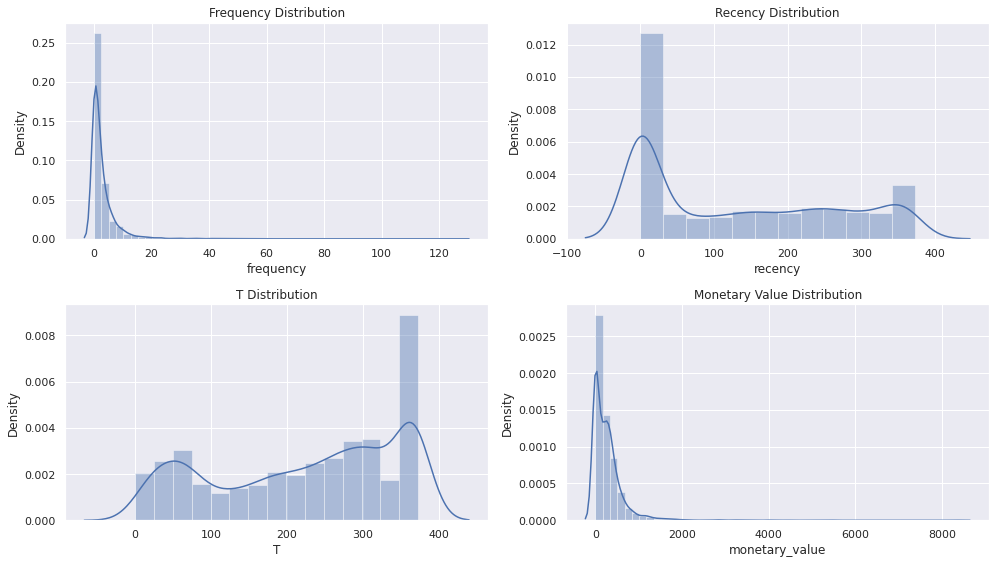

In [368]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(rfm_summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(rfm_summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(rfm_summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(rfm_summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

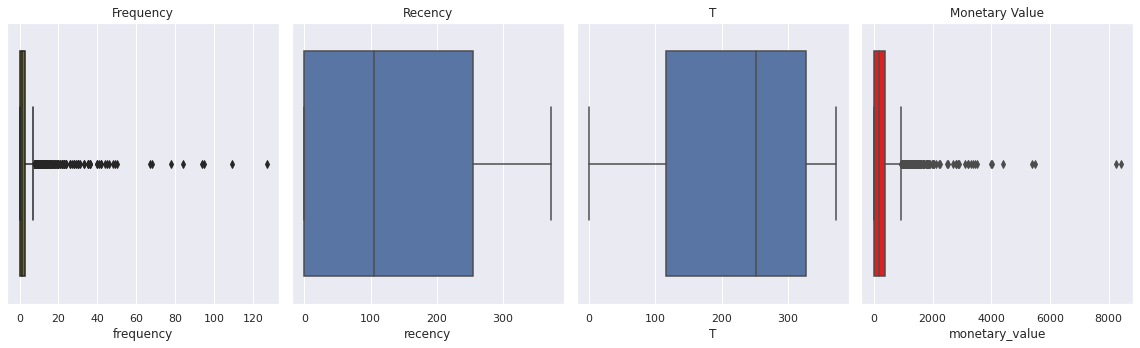

In [369]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(rfm_summary["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(rfm_summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(rfm_summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(rfm_summary["monetary_value"], color = "red")
plt.title("Monetary Value")
plt.tight_layout()

In [370]:
rfm_summary.describe()

,CustomerID,frequency,recency,T,monetary_value
count,4314.00000,4314.00000,4314.00000,4314.00000,4314.00000
mean,15348.88039,2.94089,134.26217,224.53199,271.35504
std,1700.93010,6.01875,132.99775,118.89334,416.13831
min,12346.00000,0.00000,0.00000,0.00000,0.00000
25%,13883.25000,0.00000,0.00000,116.00000,0.00000
50%,15348.50000,1.00000,105.00000,252.50000,189.98275
75%,16833.75000,3.00000,254.00000,328.00000,370.13906
max,18287.00000,127.00000,373.00000,373.00000,8416.40000


In [371]:
#checking for the values containing zero.

print("Total Number of Frequency with 0: %s" % (len(rfm_summary[rfm_summary["frequency"] == 0])))
print("Total Number of Recency with 0: %s" % (len(rfm_summary[rfm_summary["recency"] == 0])))
print("Total Number of Monetary Value with 0: %s" % (len(rfm_summary[rfm_summary["monetary_value"] == 0])))

Total Number of Frequency with 0: 1496
Total Number of Recency with 0: 1496
Total Number of Monetary Value with 0: 1496


Now we have the data related to the RFM, we can now start with which model we can build to predict our customer's lifetime value. First we have to figure out either we have to do the prediction based on the customer level or the aggregate level.

For this analysis I am using to predict the customer lifetime value on the customer level rather than the aggregate or a cohort level.

Before building the model, we have to understand few of the most important things. We have to understand the business context that is the type of customers (contractual or non-contractual) and their purchase opportunity (discrete or continuous). The combination of both defines the business context which going to affect our CLV estimation approach.

Basic Terms:

a) Contractual Customers - Contractual customers are subscription based customers. They churned on a defined date if they choose not to renew the subscription.

b) Non-Contractual Customers - Non Contractual customers generally exist in e-commerce or retail business where there's no defined time period when the customer is going to churn.

c) Continuous Purchase - It refers to the time period when the customer purchase a certain thing in any time period. Ex- Retail & E-commerce.

d) Discrete Purchase - It refers to the time period when the customer purchase a certain thing on a specific time period. Ex - Netflix, Hulu, Hotstar Subscription.

For this analysis we are going to use the non-contractual with continuous purchase opportunity and the best fitted models we are going to use will be BG-NBD Model, Pareto-NBD Model, Modifies BG Model along with Gamma Gamma Distribution model for estimating the expected monetary value as a part of the customer lifetime value prediction.


# Beta Geo - Negative Binomial Distribution + Gamma Gamma Distribution Model **bold text**

In [372]:
summary_bgf = rfm_summary.copy()

In [373]:
summary_bgf.head(2)

,CustomerID,frequency,recency,T,monetary_value
0,12346.00000,6.00000,196.00000,360.00000,47.14333
1,12347.00000,1.00000,37.00000,39.00000,711.79000


There are 4339 customers under our analysis.
CustomerID 12346 made 1 purchase only (no repeat), so the frequency and recency are 0, and the age is 325 days (e.g. the duration between the first purchase and the end of the period in the analysis).

In [374]:
bgf = BetaGeoFitter(penalizer_coef = 0.1)

# We can use penalizer of 0.001 or 0.1 which we will be going to use later on based on the model performance and model selection

In [375]:
bgf.fit(summary_bgf["frequency"], summary_bgf["recency"], summary_bgf["T"])

<lifetimes.BetaGeoFitter: fitted with 4314 subjects, a: 0.00, alpha: 50.51, b: 0.00, r: 0.62>

Among all customers in our data, more than 35% of them only made purchase once (no repeat).
## Frequency/Recency Analysis Using the BG/NBD Model

In [376]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.61530,0.01517,0.58557,0.64504
alpha,50.50947,1.65207,47.27141,53.74753
a,0.00000,0.00000,-0.00000,0.00000
b,0.00000,0.02416,-0.04736,0.04736


In [377]:
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4314 subjects, a: 0.00, alpha: 50.51, b: 0.00, r: 0.62>


### Visualizing our frequency/recency matrix
Let's do some hypothetical analysis-
- Customer who purchased every day for four weeks straight, and no transactions in months; chances of that customer being alive is less. 
- On the other hand, a customer who historically made purchase once a quarter, and again last quarter, is likely still alive. We can visualize this relationship using the frequency/recency matrix, which computes the expected number of transactions an artificial customer is to make in the next time period, given the recency (age at last purchase) and frequency (the number of repeat transactions  made).

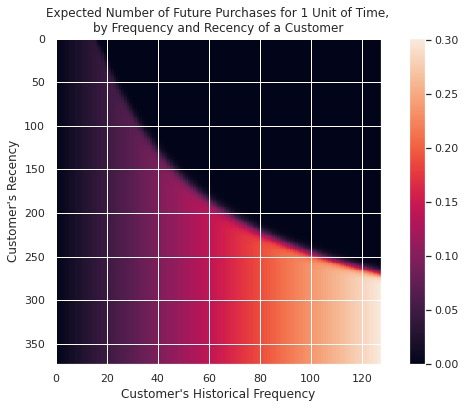

In [378]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(bgf)
plt.show()

We can see that, if a customer has made 120 purchases, and their latest purchase was when they were approximately 350 days old (i.e. Recency: the duration between their first transaction and their latest transaction is 350 days), then they are our best customer (bottom-right).

Customers who have purchased a lot and purchased recently will likely be the best customers in the future. We will never have enough of them.

Customers who have purchased a lot but not recently (top-right corner), have probably gone.
There are also another type of customers that around (40, 100) that represents the customer who buys infrequently, and we have not seen them recently, so they might buy again. However, we are not sure if they have gone or just between purchases.

Another interesting matrix to look at is the probability of still being alive:


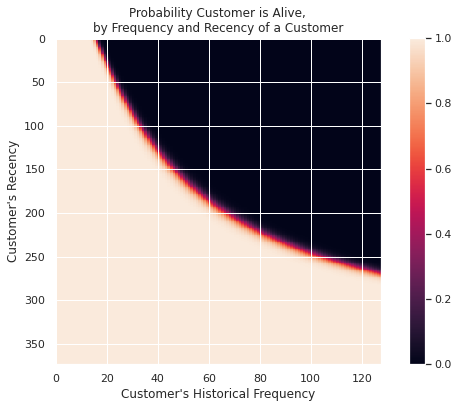

In [379]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(10,6))
plot_probability_alive_matrix(bgf)
plt.show()

Customers who have purchased recently are almost surely “alive”.
Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out. They are represented in the upper-right.

**Ranking customers from best to worst**

Let’s return to our customers and rank them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [380]:
t = 30
summary_bgf['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary_bgf['frequency'], summary_bgf['recency'], summary_bgf['T'])
summary_bgf.sort_values(by='predicted_purchases').tail(10)

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases
4077,17961.00000,49.00000,366.00000,373.00000,34.63265,3.51458
3653,17377.00000,50.00000,372.00000,372.00000,263.32900,3.59391
506,13089.00000,67.00000,369.00000,372.00000,858.86463,4.80098
1546,14527.00000,68.00000,372.00000,372.00000,269.99544,4.87198
1270,14156.00000,78.00000,367.00000,373.00000,2506.40949,5.56885
3991,17841.00000,84.00000,372.00000,372.00000,349.54452,6.00805
1607,14606.00000,94.00000,370.00000,371.00000,196.69585,6.73403
251,12748.00000,95.00000,370.00000,370.00000,238.51326,6.82139
2135,15311.00000,109.00000,373.00000,373.00000,506.24073,7.76478
1842,14911.00000,127.00000,373.00000,373.00000,1192.23575,9.03984


Listed above are our top 10 customers that the model expects them to make purchases in the next day. We can see that the customer who has made 131 purchases, and bought very recently from us, is probably going to buy again in the next period.


The predicted_purchases column represents their expected number of purchases while the other three columns represent their current RF metrics. The BG/NBD model believes these individuals will be making more purchases within the near future as they are our current best customers.
#### Assessing model fit
So far, we can predict and we can visualize our customers’ behavior. Now let us assess the model’s correctness. The ﬁrst is to compare your data versus artiﬁcial data simulated with our ﬁtted model’s parameters.


CPU times: user 684 ms, sys: 14.1 ms, total: 698 ms
Wall time: 693 ms


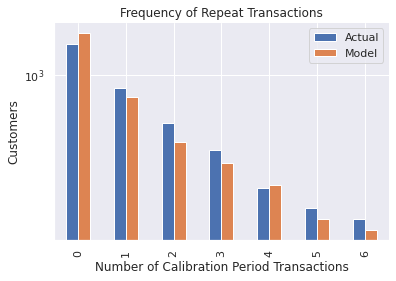

In [381]:
%%time 

from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(bgf, max_frequency=7)
ax.set_yscale('log')
sns.despine();

We can see that our actual data and our simulated data line up well. 
So, we can continue on with our analysis. We now partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (just like cross-validation in machine learning practice).

### Example using transactional datasets
Most often, the dataset you have at hand will be at the transaction level. Lifetimes has some utility functions to transform that transactional data (one row per purchase) into summary data (a frequency, recency and age dataset).

In [382]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_history_alive
transaction_data = load_transaction_data()
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


In [383]:
#dividing our dataset into training & holdout
summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2021-06-08',
                                                  observation_period_end = '2021-12-09')

In [384]:
bgf.fit(summary_cal_holdout["frequency_cal"],
       summary_cal_holdout["recency_cal"],
       summary_cal_holdout["T_cal"])

<lifetimes.BetaGeoFitter: fitted with 2782 subjects, a: 0.00, alpha: 43.13, b: 0.00, r: 0.55>

### More model fitting
With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature).

In [385]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.00000,5.00000,78.00000,176.00000,1.00000,184.00000
12349.00000,1.00000,19.00000,40.00000,1.00000,184.00000
12355.00000,0.00000,0.00000,18.00000,0.00000,184.00000
12358.00000,1.00000,181.00000,182.00000,1.00000,184.00000
12359.00000,3.00000,108.00000,185.00000,2.00000,184.00000
...,...,...,...,...,...
18281.00000,0.00000,0.00000,28.00000,0.00000,184.00000
18283.00000,2.00000,37.00000,109.00000,2.00000,184.00000
18285.00000,0.00000,0.00000,111.00000,0.00000,184.00000


With this dataset, we can perform ﬁtting on the _cal columns, and test on the _holdout columns:


CPU times: user 54.2 ms, sys: 44.4 ms, total: 98.6 ms
Wall time: 52.5 ms


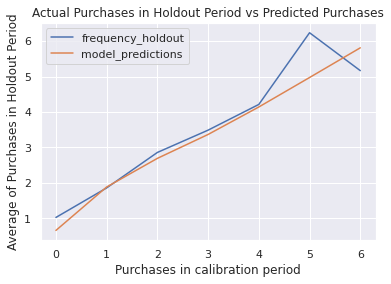

In [386]:
%%time 

from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [387]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.00000,5.00000,78.00000,176.00000,1.00000,184.00000
12349.00000,1.00000,19.00000,40.00000,1.00000,184.00000
12355.00000,0.00000,0.00000,18.00000,0.00000,184.00000
12358.00000,1.00000,181.00000,182.00000,1.00000,184.00000
12359.00000,3.00000,108.00000,185.00000,2.00000,184.00000


In [388]:
#Creating a function which can predict the future purchased value based on the lookup window

def bgf_get_pred_error(t, id_):
    
    individual = summary_bgf[summary_bgf["CustomerID"] == id_]
    
    ind_pred = bgf.predict(t, individual["frequency"], individual["recency"], individual["T"])
    
    actual_val = individual["frequency"]/individual["recency"]*t
    
    error = actual_val - ind_pred
    
    print("Your Predicted Purchase: %s" % (ind_pred))
    print("Your Actual Purchase: %s" % (actual_val))
    print("Prediction Error: %s" % (error))

In [389]:
bgf_get_pred_error(15, 12348.0)

Your Predicted Purchase: 2   0.07144
dtype: float64
Your Actual Purchase: 2   NaN
dtype: float64
Prediction Error: 2   NaN
dtype: float64


In [390]:
id_1 = 14606.0
id_2 = 12347.0

In [391]:
days_since_birth = 365

In [392]:
sp_trans_1 = data[data["CustomerID"] == id_1]
sp_trans_2 = data[data["CustomerID"] == id_2]

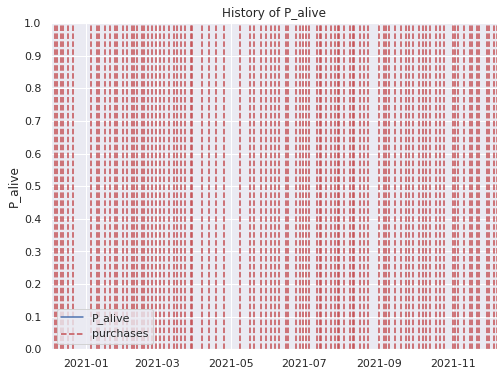

In [393]:
plt.figure(figsize=(8,6))
plot_history_alive(bgf, days_since_birth, sp_trans_1, "InvoiceDate")

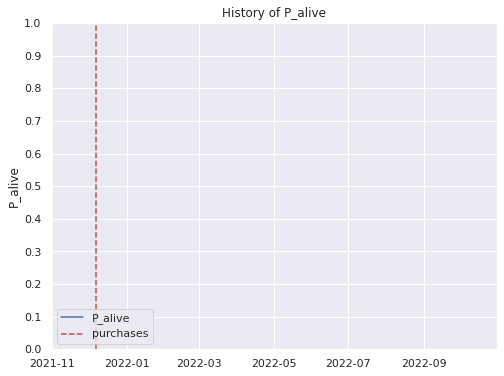

In [394]:
plt.figure(figsize=(8,6))
plot_history_alive(bgf, days_since_birth, sp_trans_2, "InvoiceDate")

In [395]:
summary_bgf["actual_30"] = summary_bgf["frequency"]/summary_bgf["recency"]*30

In [396]:
summary_bgf.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.48345,0.91837
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.54139,0.81081
2,12348.00000,0.00000,0.00000,73.00000,0.00000,0.14945,NaN
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.28582,0.32967
4,12351.00000,0.00000,0.00000,10.00000,0.00000,0.30506,NaN


In [397]:
summary_bgf = summary_bgf.fillna(value = 0) #filling null values with 0

In [398]:
#calculating the prediction error for the 30 days purchase prediction
summary_bgf["Error"] = summary_bgf["actual_30"] - summary_bgf["predicted_purchases"]

In [399]:
mse = mean_squared_error(summary_bgf["actual_30"],summary_bgf["predicted_purchases"])

In [400]:
print("Mean Squared Error: %s" % mse)
print("Average Error:  %s" % summary_bgf["Error"].mean())
print("Root Mean Squared Error: %s" % sqrt(mse))

Mean Squared Error: 1.830905138886138
Average Error:  0.20699432471980667
Root Mean Squared Error: 1.353109433448063


In [401]:
#Purchase Prediction

bgf_mse_purchase_30 = mean_squared_error(summary_bgf["actual_30"],summary_bgf["predicted_purchases"])
bgf_rmse_purchase_30 = sqrt(bgf_mse_purchase_30)
bgf_avg_error_purchase_30 = summary_bgf["Error"].mean()

In [402]:
summary_bgf.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.48345,0.91837,0.43492
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.54139,0.81081,0.26943
2,12348.00000,0.00000,0.00000,73.00000,0.00000,0.14945,0.00000,-0.14945
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.28582,0.32967,0.04385
4,12351.00000,0.00000,0.00000,10.00000,0.00000,0.30506,0.00000,-0.30506


In [403]:
#Filtering the data where we have the values of 0 or less than 0.
res_summary = summary_bgf[summary_bgf["frequency"] > 0]

In [404]:
final_summary = res_summary[res_summary["monetary_value"] > 0]

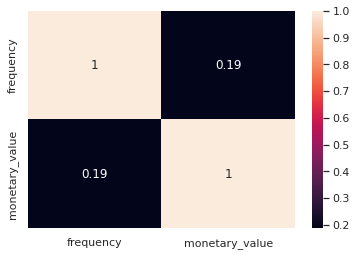

In [405]:
sns.heatmap(final_summary[["frequency", "monetary_value"]].corr(), annot = True)

To proceed with the Gamma Gamma Model we have to check for the assumption whether the frequency and monetary values are intercorrelated or not. As we can see here, the correlation between the frequency and monetary value is pretty low so we can go ahead to build Gamma Gamma Model

In [406]:
ggf_gamma = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)

In [407]:
ggf_gamma.fit(final_summary["frequency"], final_summary["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 2818 subjects, p: 2.21, q: 3.62, v: 501.98>

In [408]:
ggf_gamma.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.20530,0.12124,1.96767,2.44293
q,3.62131,0.14801,3.33121,3.91142
v,501.97960,45.33008,413.13265,590.82656


In [409]:
summary_bgf.head(2)

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.48345,0.91837,0.43492
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.54139,0.81081,0.26943


In [410]:
summary_ = summary_bgf[(summary_bgf["monetary_value"] > 0) & (summary_bgf["frequency"] > 0)]

In [411]:
summary_.shape

(2818, 8)

In [412]:
summary_["Expected_Avg_Sales"] = ggf_gamma.conditional_expected_average_profit(summary_["frequency"], 
                                                                        summary_["monetary_value"])

In [413]:
summary_.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.48345,0.91837,0.43492,109.17768
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.54139,0.81081,0.26943,554.57583
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.28582,0.32967,0.04385,660.02946
5,12352.00000,1.00000,17.00000,27.00000,200.05000,0.62520,1.76471,1.13950,320.75993
8,12356.00000,2.00000,44.00000,59.00000,1325.90500,0.71646,1.36364,0.64718,989.06891


In [414]:
print("Expected Average Sales: %s" % summary_["Expected_Avg_Sales"].mean())
print("Actual Average Sales: %s" % summary_["monetary_value"].mean())
print("Difference: %s" % (summary_["monetary_value"].mean() - summary_["Expected_Avg_Sales"].mean()))
print("Mean Squared Error: %s" % mean_squared_error(summary_["monetary_value"], summary_["Expected_Avg_Sales"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(summary_["monetary_value"], summary_["Expected_Avg_Sales"])))

Expected Average Sales: 428.1545844791941
Actual Average Sales: 415.4100912840648
Difference: -12.744493195129337
Mean Squared Error: 18870.710134664303
Root Mean Squared Error: 137.3707033346787


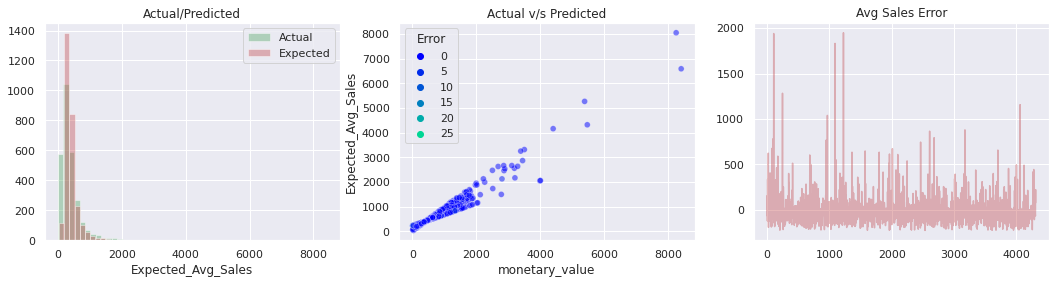

In [415]:
plt.figure(figsize=(18,4))
plt.subplot(131)
sns.distplot(summary_["monetary_value"], color = "g", kde = False)
sns.distplot(summary_["Expected_Avg_Sales"], color = "r", kde = False)
plt.title("Actual/Predicted")
plt.legend(["Actual", "Expected"])
plt.subplot(132)
sns.scatterplot(summary_["monetary_value"], summary_["Expected_Avg_Sales"], alpha = 0.5, hue = summary_["Error"], palette = "winter")
plt.title("Actual v/s Predicted")
plt.subplot(133)
plt.plot(summary_["monetary_value"]-summary_["Expected_Avg_Sales"], color = 'r', alpha = 0.4)
plt.title("Avg Sales Error")
plt.show()

In [416]:
summary_["predicted_clv"] = ggf_gamma.customer_lifetime_value(bgf,
                                                       summary_["frequency"],
                                                       summary_["recency"],
                                                       summary_["T"],
                                                       summary_["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [417]:
summary_.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.48345,0.91837,0.43492,109.17768,1374.04675
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.54139,0.81081,0.26943,554.57583,8119.07701
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.28582,0.32967,0.04385,660.02946,4883.94746
5,12352.00000,1.00000,17.00000,27.00000,200.05000,0.62520,1.76471,1.13950,320.75993,5499.46780
8,12356.00000,2.00000,44.00000,59.00000,1325.90500,0.71646,1.36364,0.64718,989.06891,19142.31261


In [418]:
#adding a 5% of profit margin
summary_["CLV"] = summary_["predicted_clv"]*0.05

In [419]:
summary_[summary_["CustomerID"] == 13902.0]

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv,CLV
1091,13902.00000,4.00000,92.00000,359.00000,8416.40000,0.33811,1.30435,0.96624,6585.06795,57725.33878,2886.26694


In [420]:
summary_.sort_values(by = "Error", ascending = False)

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv,CLV
2471,15794.00000,1.00000,1.00000,372.00000,102.00000,0.11469,30.00000,29.88531,275.96052,799.32819,39.96641
3831,17622.00000,1.00000,1.00000,233.00000,393.33000,0.17093,30.00000,29.82907,409.07028,1781.33172,89.06659
2528,15873.00000,1.00000,1.00000,135.00000,138.24000,0.26122,30.00000,29.73878,292.51871,1974.57686,98.72884
1859,14933.00000,1.00000,1.00000,79.00000,885.00000,0.37417,30.00000,29.62583,633.71613,6239.15782,311.95789
1025,13804.00000,1.00000,1.00000,71.00000,30.00000,0.39881,30.00000,29.60119,243.06345,2560.78166,128.03908
...,...,...,...,...,...,...,...,...,...,...,...
3490,17181.00000,1.00000,222.00000,230.00000,155.52000,0.17275,0.13514,-0.03762,300.41401,1322.54723,66.12736
1334,14237.00000,1.00000,217.00000,225.00000,161.00000,0.17589,0.13825,-0.03764,302.91784,1358.43779,67.92189
4004,17857.00000,1.00000,276.00000,276.00000,1335.20000,0.14842,0.10870,-0.03972,839.41418,3162.78653,158.13933
3619,17339.00000,1.00000,144.00000,144.00000,60.00000,0.24913,0.20833,-0.04080,256.77057,1649.90786,82.49539


In [421]:
actual = summary_["monetary_value"]*summary_["actual_30"]

In [422]:
pred = summary_["Expected_Avg_Sales"]*summary_["predicted_purchases"]

In [423]:
error = actual - pred

In [424]:
result = pd.DataFrame([actual, pred, error], index = ["Actual", "Predicted", "Error"]).T

In [425]:
print("Average Error: %s" % result["Error"].mean())
print("Mean Squared Error: %s" % mean_squared_error(result["Actual"], result["Predicted"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result["Actual"], result["Predicted"])))

Average Error: 128.9389024766563
Mean Squared Error: 540605.9919647229
Root Mean Squared Error: 735.2591325272491


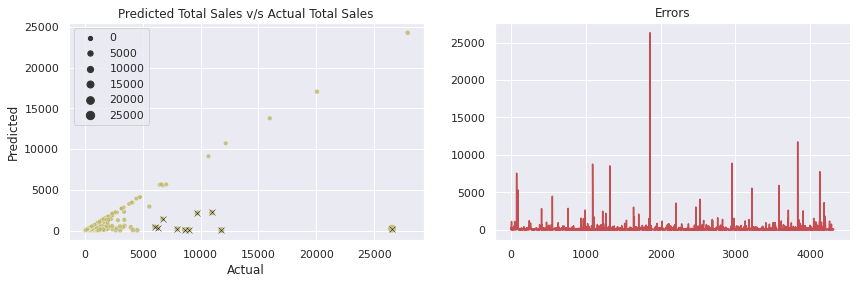

In [426]:
#Predicted v/s Actual
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.scatterplot(result["Actual"], result["Predicted"], size = result["Error"], color = "darkkhaki", alpha = 0.8, marker = 'o')
sns.scatterplot((result[result["Error"] > 5000]["Actual"]), (result[result["Error"] > 5000]["Predicted"]), color = "k", marker = "x")
plt.title("Predicted Total Sales v/s Actual Total Sales")
plt.subplot(122)
plt.plot(result["Error"], color = "r")
plt.title("Errors")
plt.show()

In [427]:
#exporting the result to csv
summary_.to_csv("customer_lifetime_value_prediction.csv")

## Saving and loading model
When we have  lots of data and training takes a lot of time option with saving and loading model could be useful. First we need to ﬁt the model, then save it and load.

### Fit model



In [428]:
###from lifetimes import BetaGeoFitter 
#from lifetimes.datasets import load_cdnow_summary
#data = load_cdnow_summary(index_col=[0]) 
#bgf = BetaGeoFitter() 
#bgf.fit(summary['frequency'], summary['recency'], summary['T']) 
#bgf 

### Saving model
Model will be saved with dill to pickle object. Optional parameters save_data and save_generate_data_method are present to reduce ﬁnal pickle object size for big dataframes. Optional parameters: 
- save_data is used for saving data from model or not (default: True). 
- save_generate_data_method is used for saving generate_new_data method from model or not (default: True)


In [429]:
#bgf.save_model('bgf.pkl')


### Loading model
Before loading we should initialize the model ﬁrst and then use method load_model


In [430]:
#bgf_loaded = BetaGeoFitter() 
#bgf_loaded.load_model('bgf.pkl') 
#bgf_loaded 

In [431]:
#ggf.save_model('ggf.pkl')

In [432]:
#ggf_loaded = GammaGammaFitter() 
#ggf_loaded.load_model('ggf.pkl') 
#ggf_loaded 

# **PARETO/NBD MODEL + Gamma Gamma Distribution Model**

In [433]:
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt

In [434]:
#summary_pnbd = rfm_summary.copy()

In [435]:
def get_model(data, penalizer_val, time):
    
    pareto_result = data.copy()

    pareto_model = ParetoNBDFitter(penalizer_coef = penalizer_val)
    pareto_model.fit(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

    #calculating the predicted_purchases

    t = time

    pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])


    pareto_result["Actual_Purchases"] = pareto_result["frequency"]/pareto_result["recency"]*time

    #filling the null values
    pareto_result["Actual_Purchases"].fillna(0, inplace = True)


    #calculating the error
    pareto_result["Prediction_Error"] = pareto_result["Actual_Purchases"]-pareto_result["predicted_purchases"]

    #calcuating the purchase prediction error
    pareto_mse_purchase = mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_r2_purchase = r2_score(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_rmse_purchase = sqrt(mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"]))
    pareto_avg_error_purchase = pareto_result["Prediction_Error"].mean()
    
    #printing the purchase prediction error
    print("Predicted Purchase Mean Squared Error: %s" %(pareto_mse_purchase))
    print("Predicted Purchase R2 Score: %s" %(pareto_r2_purchase))
    print("Predicted Purchase Root Mean Squared Error: %s" %(pareto_rmse_purchase))
    print("Predicted Purchase Average Purchases Error: %s" %(pareto_avg_error_purchase))
    
    
    #plotting the prediction v/s actual purchase plot
    plt.figure(figsize=(6,4))
    plt.errorbar(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"], yerr=pareto_result["Prediction_Error"], fmt='o', color='darkseagreen',
                 ecolor='grey', elinewidth=1.5, capsize=0, alpha = 0.2);
    plt.title("Prediction v/s Actual")

Predicted Purchase Mean Squared Error: 1.849752416241441
Predicted Purchase R2 Score: 0.11906232193532096
Predicted Purchase Root Mean Squared Error: 1.3600560342285317
Predicted Purchase Average Purchases Error: 0.20590708700578905


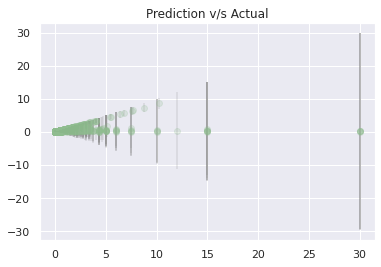

In [436]:
get_model(rfm_summary, 0.001, 30)

In [437]:
pareto_model = lifetimes.ParetoNBDFitter(penalizer_coef = 0.1)

In [438]:
pareto_model.fit(rfm_summary["frequency"],rfm_summary["recency"],
                rfm_summary["T"])

<lifetimes.ParetoNBDFitter: fitted with 4314 subjects, alpha: 72.23, beta: 356.76, r: 0.88, s: 0.00>

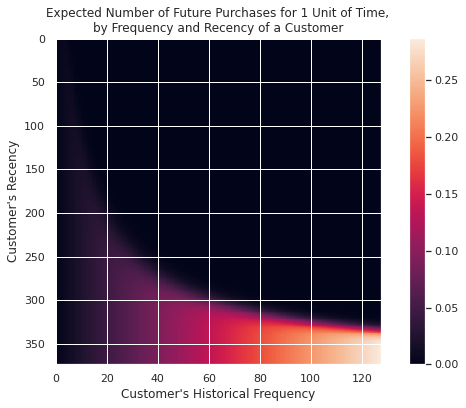

In [439]:
plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(pareto_model)

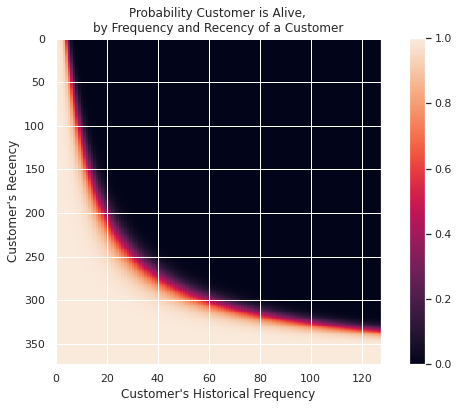

In [440]:
plt.figure(figsize=(10,6))
plot_probability_alive_matrix(pareto_model)

In [441]:
pareto_result = rfm_summary.copy()

In [442]:
pareto_result["p_not_alive"] = 1-pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])
pareto_result["p_alive"] = pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [443]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.00557,0.99443
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.00001,0.99999
2,12348.00000,0.00000,0.00000,73.00000,0.00000,0.00073,0.99927
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.00027,0.99973
4,12351.00000,0.00000,0.00000,10.00000,0.00000,0.00009,0.99991


In [444]:
t = 30
pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"],pareto_result["T"])
pareto_result

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.00557,0.99443,0.47480
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.00001,0.99999,0.50685
2,12348.00000,0.00000,0.00000,73.00000,0.00000,0.00073,0.99927,0.18151
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.00027,0.99973,0.29151
4,12351.00000,0.00000,0.00000,10.00000,0.00000,0.00009,0.99991,0.32078
...,...,...,...,...,...,...,...,...
4309,18283.00000,4.00000,276.00000,293.00000,135.10500,0.00009,0.99991,0.40074
4310,18284.00000,0.00000,0.00000,66.00000,0.00000,0.00065,0.99935,0.19072
4311,18285.00000,0.00000,0.00000,295.00000,0.00000,0.00345,0.99655,0.07159
4312,18286.00000,1.00000,247.00000,358.00000,833.48000,0.00065,0.99935,0.13096


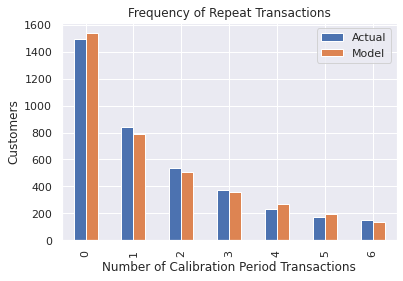

In [445]:
plot_period_transactions(pareto_model)

In [446]:
#dividing our dataset into training & holdout
pareto_summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2021-06-08',
                                                  observation_period_end = '2021-12-09')

In [447]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.00000,5.00000,78.00000,176.00000,1.00000,184.00000
12349.00000,1.00000,19.00000,40.00000,1.00000,184.00000
12355.00000,0.00000,0.00000,18.00000,0.00000,184.00000
12358.00000,1.00000,181.00000,182.00000,1.00000,184.00000
12359.00000,3.00000,108.00000,185.00000,2.00000,184.00000


In [448]:
pareto_model.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 2782 subjects, alpha: 68.06, beta: 432.99, r: 0.86, s: 0.00>

In [449]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

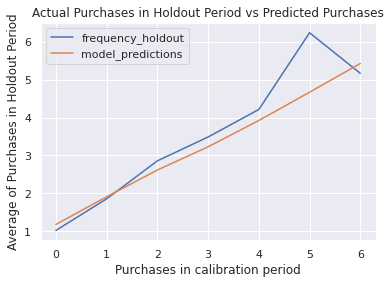

In [450]:
plot_calibration_purchases_vs_holdout_purchases(pareto_model, pareto_summary_cal_holdout)

In [451]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.00000,5.00000,78.00000,176.00000,1.00000,184.00000
12349.00000,1.00000,19.00000,40.00000,1.00000,184.00000
12355.00000,0.00000,0.00000,18.00000,0.00000,184.00000
12358.00000,1.00000,181.00000,182.00000,1.00000,184.00000
12359.00000,3.00000,108.00000,185.00000,2.00000,184.00000


In [452]:
pareto_result["actual30"] = pareto_result["frequency"]/pareto_result["recency"]*30

In [453]:
pareto_result["actual30"].fillna(0, inplace = True)

In [454]:
pareto_result["error"] = pareto_result["actual30"]-pareto_result["predicted_purchases"]
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.00557,0.99443,0.47480,0.91837,0.44357
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.00001,0.99999,0.50685,0.81081,0.30396
2,12348.00000,0.00000,0.00000,73.00000,0.00000,0.00073,0.99927,0.18151,0.00000,-0.18151
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.00027,0.99973,0.29151,0.32967,0.03816
4,12351.00000,0.00000,0.00000,10.00000,0.00000,0.00009,0.99991,0.32078,0.00000,-0.32078


In [455]:
print("Mean Squared Error: %s" % mean_squared_error(pareto_result["actual30"], pareto_result["predicted_purchases"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(pareto_result["actual30"], pareto_result["predicted_purchases"])))
print("Average Purchase Error: %s" %(pareto_result["error"].mean()))

Mean Squared Error: 1.8495466067850876
Root Mean Squared Error: 1.3599803699999085
Average Purchase Error: 0.2058254580850368


In [456]:
pareto_mse_purchase = mean_squared_error(pareto_result["actual30"], pareto_result["predicted_purchases"])
pareto_rmse_purchase = sqrt(mean_squared_error(pareto_result["actual30"], pareto_result["predicted_purchases"]))
pareto_avg_error_purchase = pareto_result["error"].mean()

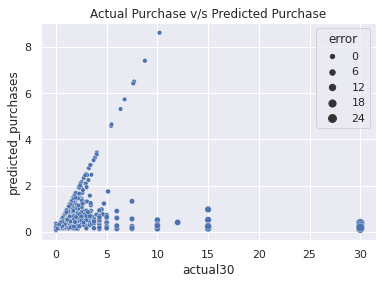

In [457]:
sns.scatterplot(pareto_result["actual30"], pareto_result["predicted_purchases"], size = pareto_result["error"])
plt.title("Actual Purchase v/s Predicted Purchase")
plt.show()

In [458]:
#Get the history alive plot to check whether the customer is alive or not

def get_history_alive(t_, data_, id_):
    
    individual_alive = data[data["CustomerID"] == id_]
    plot_history_alive(pareto_model, t = t_, transactions = individual_alive, datetime_col = "InvoiceDate",
                  freq = "D")

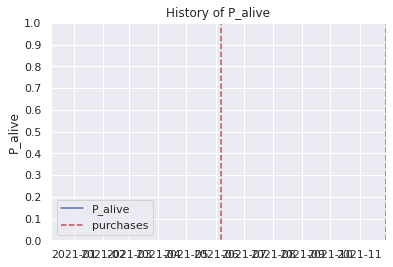

In [459]:
get_history_alive(30, data, 12358.0)

**GAMMA-GAMMA MODEL**

In [460]:
idx = pareto_result[(pareto_result["frequency"] <= 0.0)]

In [461]:
idx = idx.index

In [462]:
ggf_filter = pareto_result.drop(idx, axis = 0)

In [463]:
m_idx = ggf_filter[(ggf_filter["monetary_value"] <= 0.0)].index

In [464]:
ggf_filter = ggf_filter.drop(m_idx, axis = 0)

In [465]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

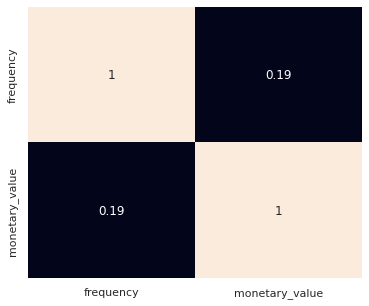

In [466]:
plt.figure(figsize=(6,5))
sns.heatmap(ggf_filter[["frequency", "monetary_value"]].corr(), annot = True, cbar = False)

In [467]:
ggf_model =  lifetimes.GammaGammaFitter(penalizer_coef=0.1)

In [468]:
ggf_model.fit(ggf_filter["frequency"], ggf_filter["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 2818 subjects, p: 1.03, q: 0.18, v: 0.93>

In [469]:
ggf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.02787,0.02974,0.96958,1.08616
q,0.17699,0.00361,0.16991,0.18407
v,0.92777,0.03106,0.86689,0.98865


In [470]:
ggf_filter["expected_avg_sales_"] = ggf_model.conditional_expected_average_profit(ggf_filter["frequency"],
                                                                                     ggf_filter["monetary_value"])

In [471]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.00557,0.99443,0.47480,0.91837,0.44357,54.58187
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.00001,0.99999,0.50685,0.81081,0.30396,3576.02613
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.00027,0.99973,0.29151,0.32967,0.03816,1337.06485
5,12352.00000,1.00000,17.00000,27.00000,200.05000,0.00008,0.99992,0.56811,1.76471,1.19660,1008.39600
8,12356.00000,2.00000,44.00000,59.00000,1325.90500,0.00013,0.99987,0.65812,1.36364,0.70552,2211.89696


In [472]:
avg_purchase_error = ggf_filter["monetary_value"].mean() - ggf_filter["expected_avg_sales_"].mean()

In [473]:
print("Acutal Avg Sales: %s" % ggf_filter["monetary_value"].mean())
print("Predicted Avg Sales: %s" % ggf_filter["expected_avg_sales_"].mean())
print("Mean Squared Error: %s" %(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))
print("Root Mean Squared Error: %s" %(sqrt(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"]))))
print("Avg Sales Error: %s" % avg_purchase_error)
print("R2 Score: %s" %(r2_score(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))

Acutal Avg Sales: 415.4100912840648
Predicted Avg Sales: 935.8175144154607
Mean Squared Error: 1258941.4030418342
Root Mean Squared Error: 1122.0255803865766
Avg Sales Error: -520.407423131396
R2 Score: -5.135204964615057


In [474]:
actual = ggf_filter["actual30"] * ggf_filter["monetary_value"]
predicted = ggf_filter["predicted_purchases"] * ggf_filter["expected_avg_sales_"]

In [475]:
error = actual-predicted

In [476]:
result_p = pd.DataFrame([actual, predicted, error], index = ["Actual", "Predicted", "Error"]).T

In [477]:
print("Average Error: %s" % result_p["Error"].mean())
print("Mean Squared Error: %s" % mean_squared_error(result_p["Actual"], result_p["Predicted"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result_p["Actual"], result_p["Predicted"])))

Average Error: -1.9042469855843596
Mean Squared Error: 481703.13099408563
Root Mean Squared Error: 694.0483635843295


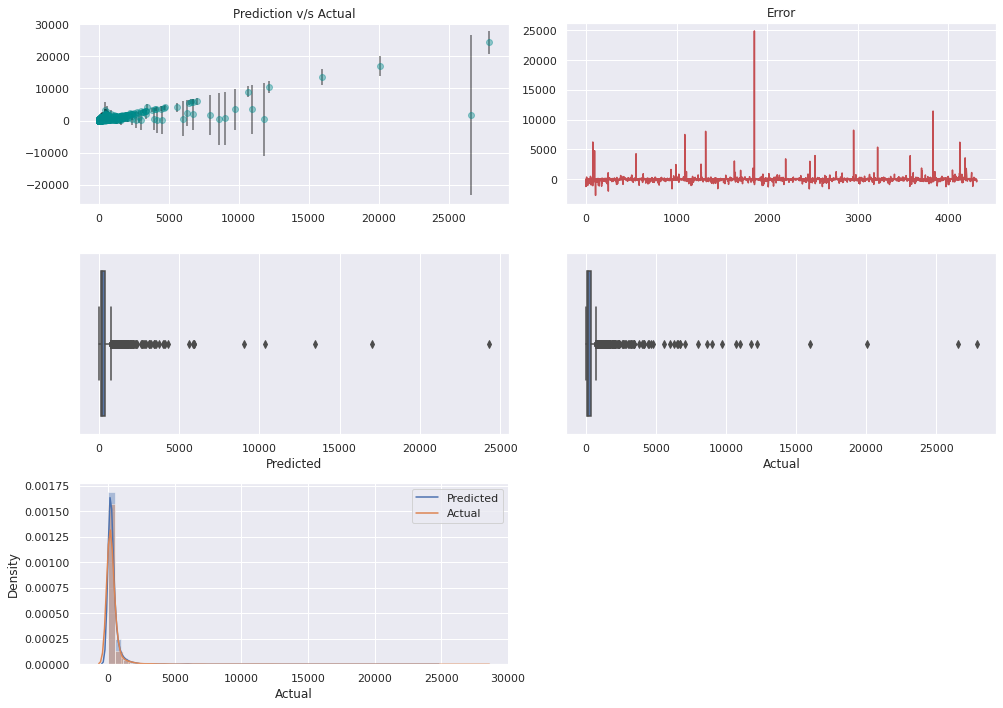

In [478]:
plt.figure(figsize=(14,10))
plt.subplot(321)
plt.errorbar(result_p["Actual"], result_p["Predicted"], yerr=result_p["Error"], fmt='o', color='darkcyan',
             ecolor='black', elinewidth=2, capsize=0, alpha = 0.4);
plt.title("Prediction v/s Actual")
plt.subplot(322)
plt.plot(result_p["Error"], color = 'r')
plt.title("Error")
plt.subplot(323)
sns.boxplot(result_p["Predicted"])
plt.subplot(324)
sns.boxplot(result_p["Actual"])
plt.subplot(325)
sns.distplot(result_p["Predicted"])
sns.distplot(result_p["Actual"])
plt.legend(["Predicted", "Actual"])
plt.tight_layout()

In [479]:
ggf_filter["predicted_clv"] = ggf_model.customer_lifetime_value(pareto_model,
                                                       ggf_filter["frequency"],
                                                       ggf_filter["recency"],
                                                       ggf_filter["T"],
                                                       ggf_filter["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [480]:
#Top 5 customers with high CLV
ggf_filter[["CustomerID", "predicted_clv"]].sort_values(by = "predicted_clv", ascending = False).head(5)

,CustomerID,predicted_clv
4185,18102.00000,633515.33849
1638,14646.00000,443061.43716
1270,14156.00000,350582.54642
1842,14911.00000,269299.78075
939,13694.00000,235881.89530


In [481]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

In [482]:
#exporting the result to csv
ggf_filter.to_csv("customer_lifetime_value_prediction.csv")

# **Modified Beta Geom + Gamma Gamma Distribution Model**

In [483]:
summary_mbg = rfm_summary.copy()

In [484]:
summary_mbg.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.00000,6.00000,196.00000,360.00000,47.14333
1,12347.00000,1.00000,37.00000,39.00000,711.79000
2,12348.00000,0.00000,0.00000,73.00000,0.00000
3,12349.00000,2.00000,182.00000,224.00000,801.31000
4,12351.00000,0.00000,0.00000,10.00000,0.00000


In [485]:
mbg = ModifiedBetaGeoFitter(penalizer_coef = 0.1)
mbg.fit(summary_mbg["frequency"], summary_mbg["recency"], summary_mbg["T"])

<lifetimes.ModifiedBetaGeoFitter: fitted with 4314 subjects, a: 0.00, alpha: 50.51, b: 0.00, r: 0.62>

In [486]:
mbg.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.61530,0.01517,0.58557,0.64504
alpha,50.50949,1.65207,47.27143,53.74756
a,0.00000,0.00000,-0.00000,0.00000
b,0.00000,0.02407,-0.04718,0.04718


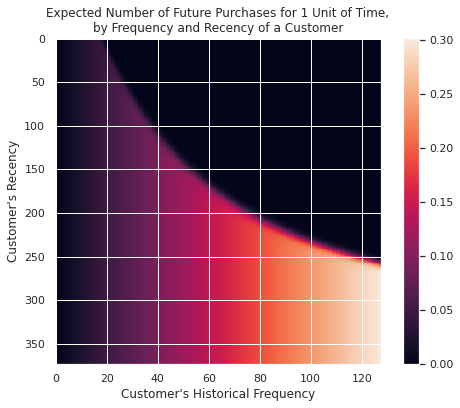

In [487]:
plt.figure(figsize=(8,6))
plot_frequency_recency_matrix(mbg)

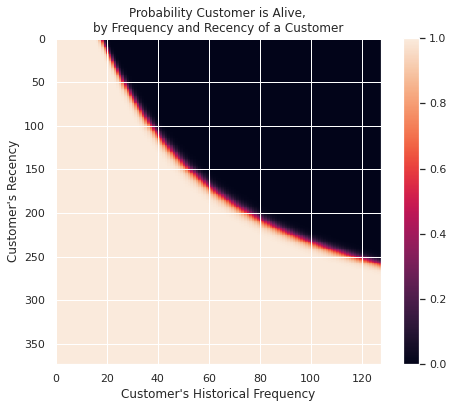

In [488]:
plt.figure(figsize=(8,6))
plot_probability_alive_matrix(mbg)

In [489]:
t = 30
summary_mbg["predicted_purchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary_mbg["frequency"], summary_mbg["recency"], summary_mbg["T"])

In [490]:
summary_mbg

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.48766
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.56728
2,12348.00000,0.00000,0.00000,73.00000,0.00000,0.14287
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.28672
4,12351.00000,0.00000,0.00000,10.00000,0.00000,0.31228
...,...,...,...,...,...,...
4309,18283.00000,4.00000,276.00000,293.00000,135.10500,0.40636
4310,18284.00000,0.00000,0.00000,66.00000,0.00000,0.15204
4311,18285.00000,0.00000,0.00000,295.00000,0.00000,0.04907
4312,18286.00000,1.00000,247.00000,358.00000,833.48000,0.11615


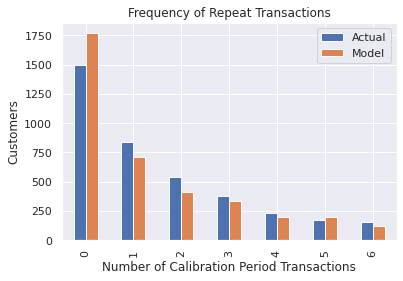

In [491]:
plot_period_transactions(mbg)

In [492]:
#dividing our dataset into training & holdout
summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2021-06-08',
                                                  observation_period_end = '2021-12-09')

In [493]:
mbg.fit(summary_cal_holdout["frequency_cal"],
       summary_cal_holdout["recency_cal"],
       summary_cal_holdout["T_cal"])

<lifetimes.ModifiedBetaGeoFitter: fitted with 2782 subjects, a: 0.00, alpha: 43.13, b: 0.00, r: 0.55>

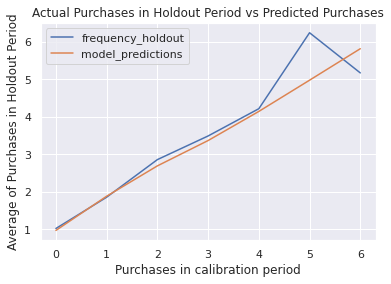

In [494]:
plot_calibration_purchases_vs_holdout_purchases(mbg, summary_cal_holdout)

In [495]:
summary_mbg["actual_30"] = summary_mbg["frequency"]/summary_mbg["recency"]*30

In [496]:
summary_mbg = summary_mbg.fillna(value = 0)

In [497]:
summary_mbg.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.48766,0.91837
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.56728,0.81081
2,12348.00000,0.00000,0.00000,73.00000,0.00000,0.14287,0.00000
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.28672,0.32967
4,12351.00000,0.00000,0.00000,10.00000,0.00000,0.31228,0.00000


In [498]:
summary_mbg["Error"] = summary_mbg["actual_30"] - summary_mbg["predicted_purchases"]

In [499]:
mse = mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"])

In [500]:
print("Mean Squared Error: %s" % mse)
print("Average Error:  %s" % summary_mbg["Error"].mean())
print("Root Mean Squared Error: %s" % sqrt(mse))

Mean Squared Error: 1.8216680518723247
Average Error:  0.20334042451815976
Root Mean Squared Error: 1.3496918358915582


In [501]:
mbg_mse_purchase = mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"])
mbg_rmse_purchase = sqrt(mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"]))
mbg_avg_purchase_error = (summary_mbg["actual_30"].mean() - summary_mbg["predicted_purchases"].mean())

In [502]:
res_summary = summary_mbg[summary_mbg["frequency"] > 0]

In [503]:
final_summary = res_summary[res_summary["monetary_value"] > 0]

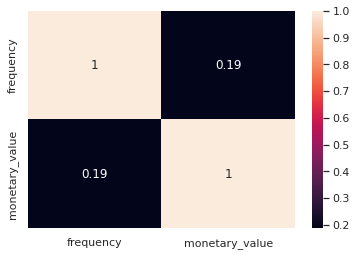

In [504]:
sns.heatmap(final_summary[["frequency", "monetary_value"]].corr(), annot = True)

In [505]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)

In [506]:
ggf.fit(final_summary["frequency"], final_summary["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 2818 subjects, p: 2.21, q: 3.62, v: 501.98>

In [507]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.20530,0.12124,1.96767,2.44293
q,3.62131,0.14801,3.33121,3.91142
v,501.97960,45.33008,413.13265,590.82656


In [508]:
summary_mbg_new = summary_mbg[(summary_mbg["monetary_value"] > 0) & (summary_mbg["frequency"] > 0)]

In [509]:
summary_mbg_new

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.48766,0.91837,0.43071
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.56728,0.81081,0.24353
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.28672,0.32967,0.04295
5,12352.00000,1.00000,17.00000,27.00000,200.05000,0.66434,1.76471,1.10036
8,12356.00000,2.00000,44.00000,59.00000,1325.90500,0.74993,1.36364,0.61371
...,...,...,...,...,...,...,...,...
4303,18276.00000,4.00000,337.00000,364.00000,275.65250,0.33550,0.35608,0.02058
4304,18277.00000,2.00000,97.00000,129.00000,366.26500,0.44496,0.61856,0.17360
4309,18283.00000,4.00000,276.00000,293.00000,135.10500,0.40636,0.43478,0.02842
4312,18286.00000,1.00000,247.00000,358.00000,833.48000,0.11615,0.12146,0.00531


In [510]:
summary_mbg_new["Expected_Avg_Sales"] = ggf.conditional_expected_average_profit(summary_mbg_new["frequency"], 
                                                                        summary_mbg_new["monetary_value"])

In [511]:
summary_mbg_new.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.48766,0.91837,0.43071,109.17768
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.56728,0.81081,0.24353,554.57583
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.28672,0.32967,0.04295,660.02946
5,12352.00000,1.00000,17.00000,27.00000,200.05000,0.66434,1.76471,1.10036,320.75993
8,12356.00000,2.00000,44.00000,59.00000,1325.90500,0.74993,1.36364,0.61371,989.06891


In [512]:
print("Expected Average Sales: %s" % summary_mbg_new["Expected_Avg_Sales"].mean())
print("Actual Average Sales: %s" % summary_mbg_new["monetary_value"].mean())
print("Difference: %s" % (summary_mbg_new["monetary_value"].mean() - summary_mbg_new["Expected_Avg_Sales"].mean()))
print("Mean Squared Error: %s" % mean_squared_error(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"])))

Expected Average Sales: 428.1545844791941
Actual Average Sales: 415.4100912840648
Difference: -12.744493195129337
Mean Squared Error: 18870.710134664303
Root Mean Squared Error: 137.3707033346787


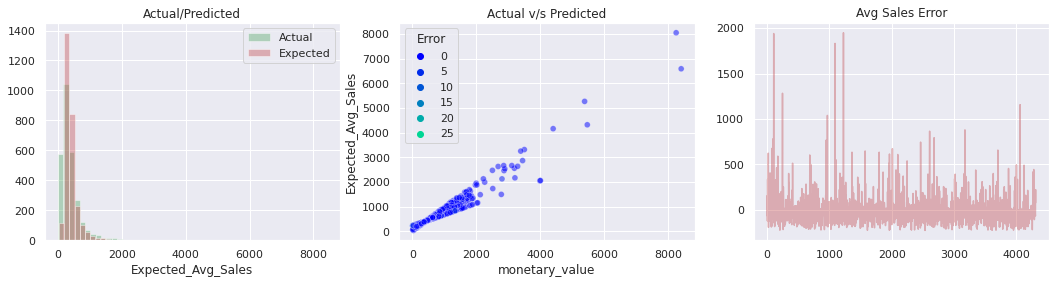

In [513]:
plt.figure(figsize=(18,4))
plt.subplot(131)
sns.distplot(summary_mbg_new["monetary_value"], color = "g", kde = False)
sns.distplot(summary_mbg_new["Expected_Avg_Sales"], color = "r", kde = False)
plt.title("Actual/Predicted")
plt.legend(["Actual", "Expected"])
plt.subplot(132)
sns.scatterplot(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"], alpha = 0.5, hue = summary_["Error"], palette = "winter")
plt.title("Actual v/s Predicted")
plt.subplot(133)
plt.plot(summary_mbg_new["monetary_value"]-summary_mbg_new["Expected_Avg_Sales"], color = 'r', alpha = 0.4)
plt.title("Avg Sales Error")
plt.show()

In [514]:
summary_mbg_new["predicted_clv"] = ggf.customer_lifetime_value(mbg,
                                                       summary_mbg_new["frequency"],
                                                       summary_mbg_new["recency"],
                                                       summary_mbg_new["T"],
                                                       summary_mbg_new["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [515]:
summary_mbg_new

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.48766,0.91837,0.43071,109.17768,1374.04675
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.56728,0.81081,0.24353,554.57583,8119.07692
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.28672,0.32967,0.04295,660.02946,4883.94739
5,12352.00000,1.00000,17.00000,27.00000,200.05000,0.66434,1.76471,1.10036,320.75993,5499.46776
8,12356.00000,2.00000,44.00000,59.00000,1325.90500,0.74993,1.36364,0.61371,989.06891,19142.31255
...,...,...,...,...,...,...,...,...,...,...
4303,18276.00000,4.00000,337.00000,364.00000,275.65250,0.33550,0.35608,0.02058,309.25022,2677.62443
4304,18277.00000,2.00000,97.00000,129.00000,366.26500,0.44496,0.61856,0.17360,387.15806,4445.89231
4309,18283.00000,4.00000,276.00000,293.00000,135.10500,0.40636,0.43478,0.02842,200.90016,2106.90508
4312,18286.00000,1.00000,247.00000,358.00000,833.48000,0.11615,0.12146,0.00531,610.17645,1829.07901


In [516]:
summary_mbg_new["CLV"] = summary_mbg_new["predicted_clv"]*0.05

In [517]:
actual = summary_["monetary_value"]*summary_["actual_30"]
pred = summary_["Expected_Avg_Sales"]*summary_["predicted_purchases"]
error = actual - pred
result = pd.DataFrame([actual, pred, error], index = ["Actual", "Predicted", "Error"]).T

In [518]:
print("Average Error: %s" % result["Error"].mean())
print("Mean Squared Error: %s" % (mean_squared_error(result["Actual"], result["Predicted"])))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result["Actual"], result["Predicted"])))

Average Error: 128.9389024766563
Mean Squared Error: 540605.9919647229
Root Mean Squared Error: 735.2591325272491


In [519]:
summary_mbg_new

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv,CLV
0,12346.00000,6.00000,196.00000,360.00000,47.14333,0.48766,0.91837,0.43071,109.17768,1374.04675,68.70234
1,12347.00000,1.00000,37.00000,39.00000,711.79000,0.56728,0.81081,0.24353,554.57583,8119.07692,405.95385
3,12349.00000,2.00000,182.00000,224.00000,801.31000,0.28672,0.32967,0.04295,660.02946,4883.94739,244.19737
5,12352.00000,1.00000,17.00000,27.00000,200.05000,0.66434,1.76471,1.10036,320.75993,5499.46776,274.97339
8,12356.00000,2.00000,44.00000,59.00000,1325.90500,0.74993,1.36364,0.61371,989.06891,19142.31255,957.11563
...,...,...,...,...,...,...,...,...,...,...,...
4303,18276.00000,4.00000,337.00000,364.00000,275.65250,0.33550,0.35608,0.02058,309.25022,2677.62443,133.88122
4304,18277.00000,2.00000,97.00000,129.00000,366.26500,0.44496,0.61856,0.17360,387.15806,4445.89231,222.29462
4309,18283.00000,4.00000,276.00000,293.00000,135.10500,0.40636,0.43478,0.02842,200.90016,2106.90508,105.34525
4312,18286.00000,1.00000,247.00000,358.00000,833.48000,0.11615,0.12146,0.00531,610.17645,1829.07901,91.45395


In [520]:
predicted_clv_results = pd.DataFrame(summary_mbg_new[["CustomerID", "predicted_clv"]])

In [524]:
predicted_clv_results = predicted_clv_results.merge(summary_mbg_new[["CustomerID", "predicted_clv"]], on = "CustomerID")

In [525]:
predicted_clv_results.columns = ["CustomerID", "BG-NBD", "Pareto-NBD", "MBG-NBD"]

In [526]:
predicted_clv_results.head(5)

,CustomerID,BG-NBD,Pareto-NBD,MBG-NBD
0,12346.00000,1374.04675,1374.04675,1374.04675
1,12347.00000,8119.07692,8119.07692,8119.07692
2,12349.00000,4883.94739,4883.94739,4883.94739
3,12352.00000,5499.46776,5499.46776,5499.46776
4,12356.00000,19142.31255,19142.31255,19142.31255


Purchase Prediction Result Summary

In [532]:
indexes = ["MSE Purchase Error", "RMSE Purchase Error","Avg Purchase Error"]

In [533]:
model_purchase_result = pd.DataFrame(data, columns = ["BG-NBD", "Pareto-NBD", "MBG-NBD"], index = indexes)

In [534]:
data = [[bgf_mse_purchase_30, pareto_mse_purchase, mbg_mse_purchase],
[bgf_rmse_purchase_30, pareto_rmse_purchase, mbg_rmse_purchase], [bgf_avg_error_purchase_30, pareto_avg_error_purchase, mbg_avg_purchase_error]]

In [535]:
model_purchase_result

,BG-NBD,Pareto-NBD,MBG-NBD
MSE Purchase Error,1.83091,1.84955,1.82167
RMSE Purchase Error,1.35311,1.35998,1.34969
Avg Purchase Error,0.20699,0.20583,0.20334


As we can see here is that there is no much difference when it comes to the performance of these models but Pareto NBD model is slightly performing better when it comes it minimizing the MSE & RMSE Errors.

In [537]:
from lifetimes import BetaGeoFitter 
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0]) 
bgf = BetaGeoFitter() 
bgf.fit(summary_rfm['frequency'], summary_rfm['recency'], summary_rfm['T']) 
bgf 

NameError: ignored

In [531]:
#Saving our model - BG/NBD
pickle.dump(bgf, open('bgf.pkl', 'wb'))

#Saving our 2nd model - Gamma Model
pickle.dump(ggf_gamma, open('ggf_gamma.pkl', 'wb'))

AttributeError: ignored

In [536]:
#Saving our model - Pareto/NBD
pickle.dump(pareto_model, open('pareto_nbd.pkl', 'wb'))

#Saving our 2nd model - Gamma Model
pickle.dump(ggf_model, open('gamma_model.pkl', 'wb'))


AttributeError: ignored

In [ ]:
#Saving our model - MBG/NBD
pickle.dump(mbg, open('mbg.pkl', 'wb'))

#Saving our 2nd model - Gamma Model
pickle.dump(ggf, open('ggf.pkl', 'wb'))